In [1]:
from __future__ import annotations
import zipfile
import pandas as pd
import os
from io import StringIO
import matplotlib.pyplot as plt
import tempfile
import plotly.express as px
import glob

In [2]:
MAIN_DIR = "/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/10_11_2024"
INPUT_DIR = MAIN_DIR + "/output"
OUTPUT_DIR = MAIN_DIR + "/output2"

In [5]:
# get the filename of each .csv file in the input directory 
files = glob.glob(INPUT_DIR + "/*.csv")
# remove motor.csv and peak.csv from the list
files = [f for f in files if "motor.csv" not in f and "peak.csv" not in f]
print(files)

['/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/10_11_2024/output/MASTER_15X14X3_AT5220_KV220_RUN2_10-7-24.csv', '/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/10_11_2024/output/TMOTOR_18X10_CFRP_AT5220_KV220_RUN1_10-7-24.csv', '/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/10_11_2024/output/APC_14X10E_AT5220_KV220_RUN2_10-8-24.csv', '/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/10_11_2024/output/APC_18X12E_AT5220_KV220_RUN3_10-8-24.csv', '/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/10_11_2024/output/APC_14X10E_AT5220_KV220_RUN1_10-8-24.csv', '/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/10_11_2024/output/APC_19X10EX12E_AT5220_KV220_RUN3_10-8-24.csv', '/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/10_11_2024/output/TMOTOR_18X10_CFRP_AT5220_KV220_RUN2_10-7-24.csv', '/Users/alex/Desktop/CS/Internships/DBF

In [31]:
df = pd.read_csv(files[0])
df.head()

,synced_iteration,torque,thrust (g),escRPM,power
0,-5476,-0.0,-0.0000,0,36.1608
1,-5400,-0.0,-0.0112,0,36.1608
2,-5381,-0.0,-0.0112,0,36.1608
3,-5310,-0.0,-0.0673,0,36.1608
4,-5286,-0.0,-0.0673,0,36.1608


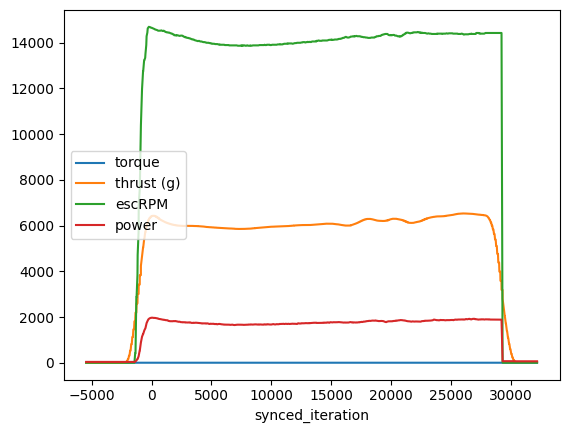

In [8]:
df.plot(x='synced_iteration')
plt.show()

,torque,thrust (g),escRPM,power,synced_iteration,synced_iteration_diff
0,-2.229600,5970.787100,14057.000000,1733.020800,0,NaN
1,-2.201658,5921.427727,13966.666667,1700.044691,2059,2059.0
2,-2.171495,5863.657936,13882.454545,1662.059359,4119,2060.0
3,-2.190751,5915.927269,13898.066667,1674.881929,6179,2060.0
4,-2.214780,5984.008264,13958.066667,1699.082258,8239,2060.0
5,-2.239918,6038.979868,14052.704545,1737.753086,10299,2060.0
6,-2.255024,6051.055760,14163.266667,1764.147718,12358,2059.0
7,-2.283230,6177.986825,14254.931818,1792.332839,14418,2060.0
8,-2.301773,6245.086866,14323.159091,1821.530518,16478,2060.0
9,-2.285811,6181.067138,14404.800000,1822.344529,18538,2060.0


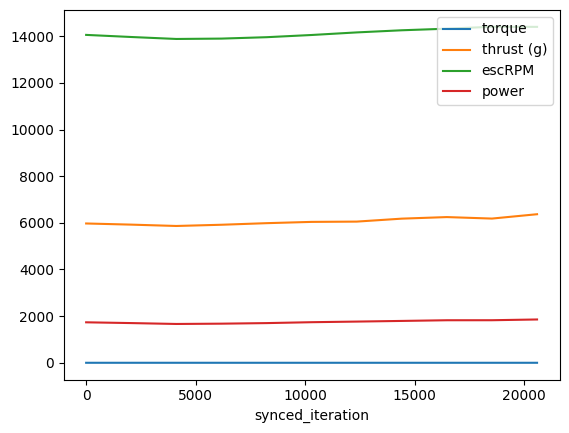

In [39]:
# pick out continuous interval near the maximum escRPM
max_value = df['escRPM'].max()
df_truncated = df[df['escRPM'] > max_value * 0.9]
# crop out the beginning and end of the interval
df_truncated = df_truncated[100:-100]
# resample the data to 10 points
n_samples = 10
start_synced_iteration = df_truncated['synced_iteration'].iloc[0]
end_synced_iteration = df_truncated['synced_iteration'].iloc[-1]
duration = end_synced_iteration - start_synced_iteration
resample_period = duration / n_samples
df_truncated = df_truncated.set_index('synced_iteration')
df_truncated.index = pd.to_datetime(df_truncated.index, unit='s')
df_truncated = df_truncated.resample(f'{resample_period}S').mean()
# convert the index back
df_truncated.index = (df_truncated.index - df_truncated.index[0]).seconds
df_truncated['synced_iteration'] = df_truncated.index
df_truncated = df_truncated.reset_index(drop=True)
# sort the data
df_truncated = df_truncated.sort_values(by='synced_iteration')
df_truncated = df_truncated.reset_index(drop=True)
df_truncated['synced_iteration_diff'] = df_truncated['synced_iteration'].diff()
display(df_truncated)
df_truncated.drop(columns=['synced_iteration_diff'], inplace=True)
# plot the resampled data
df_truncated.plot(x='synced_iteration')
plt.show()

In [40]:
def simplify_data(df, n_samples):
    # pick out continuous interval near the maximum escRPM
    max_value = df['escRPM'].max()
    df_truncated = df[df['escRPM'] > max_value * 0.9]
    # crop out the beginning and end of the interval
    df_truncated = df_truncated[100:-100]
    # resample the data to 10 points
    start_synced_iteration = df_truncated['synced_iteration'].iloc[0]
    end_synced_iteration = df_truncated['synced_iteration'].iloc[-1]
    duration = end_synced_iteration - start_synced_iteration
    resample_period = duration / n_samples
    df_truncated = df_truncated.set_index('synced_iteration')
    df_truncated.index = pd.to_datetime(df_truncated.index, unit='s')
    df_truncated = df_truncated.resample(f'{resample_period}S').mean()
    # convert the index back
    df_truncated.index = (df_truncated.index - df_truncated.index[0]).seconds
    df_truncated['synced_iteration'] = df_truncated.index
    df_truncated = df_truncated.reset_index(drop=True)
    # sort the data
    df_truncated = df_truncated.sort_values(by='synced_iteration')
    df_truncated = df_truncated.reset_index(drop=True)
    return df_truncated

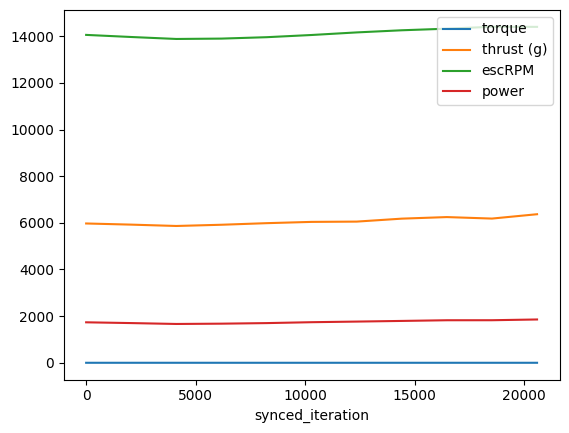

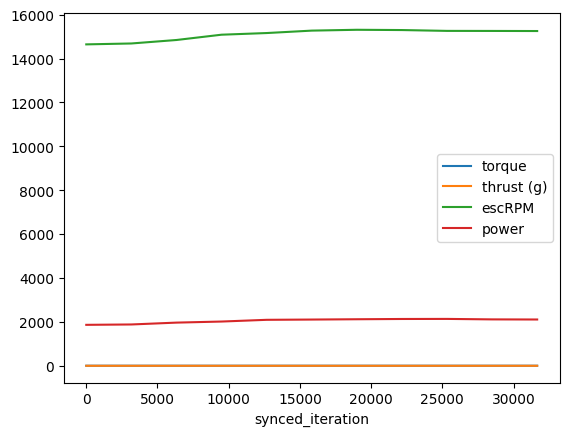

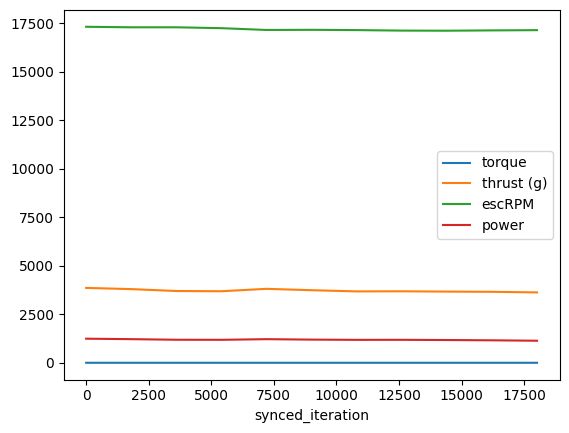

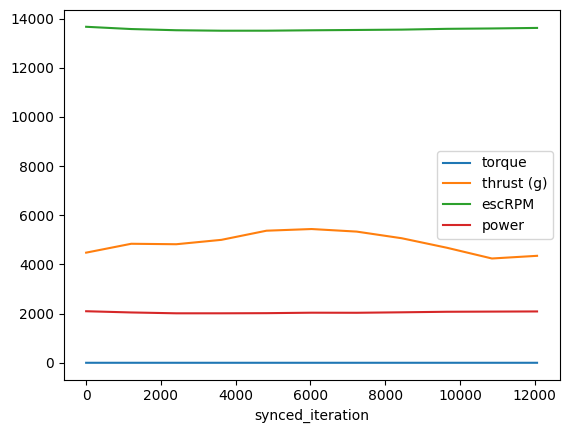

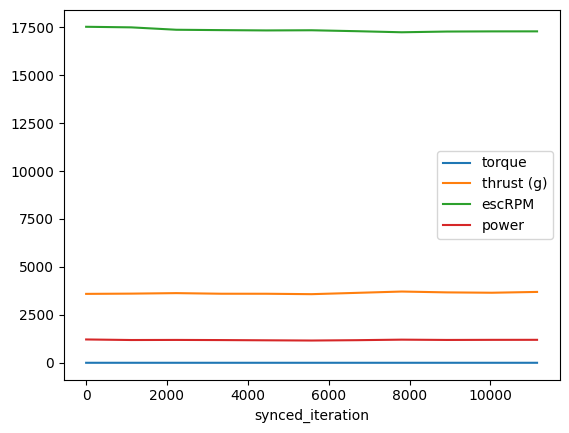

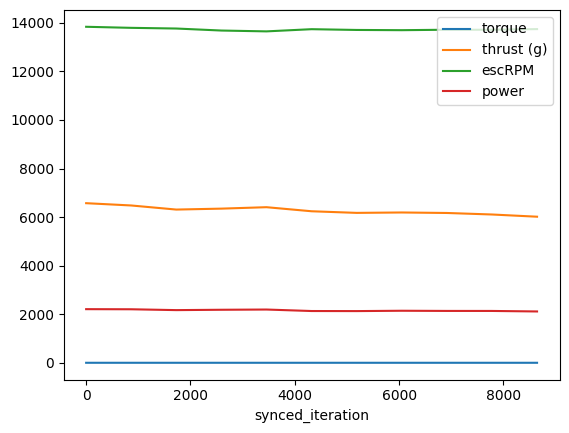

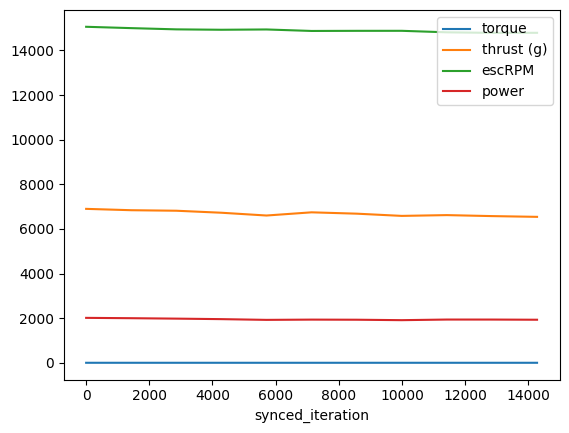

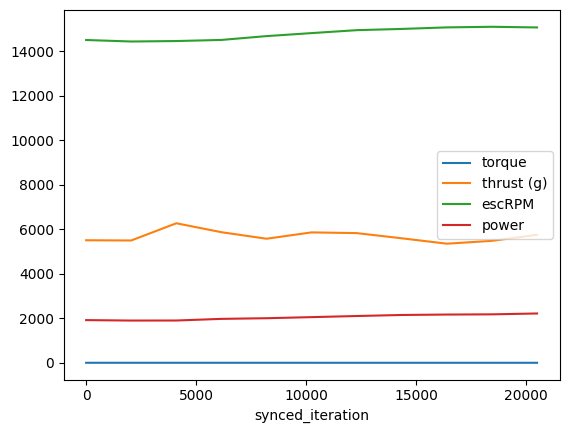

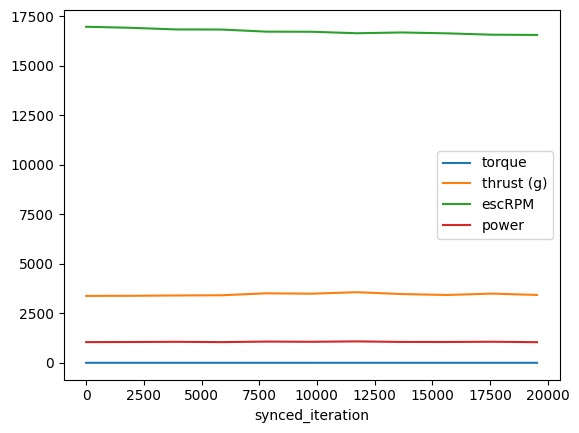

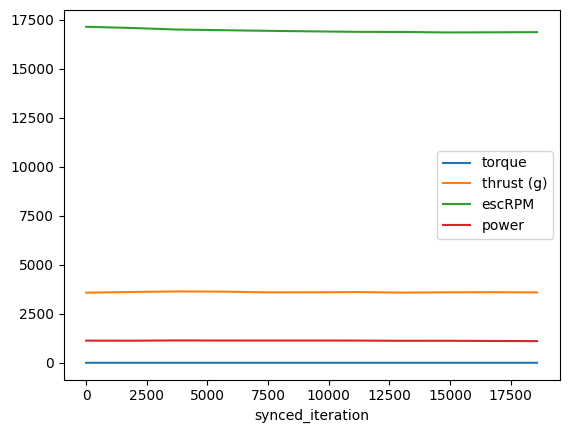

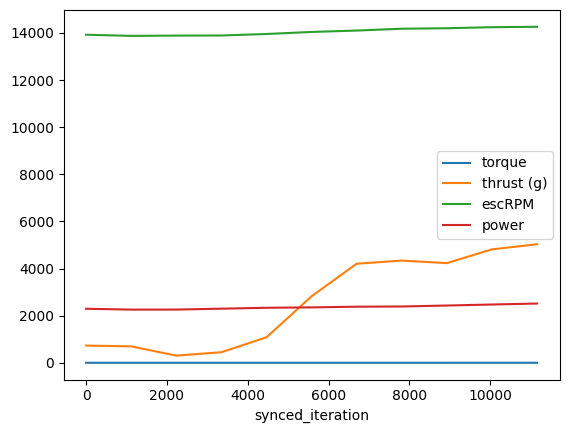

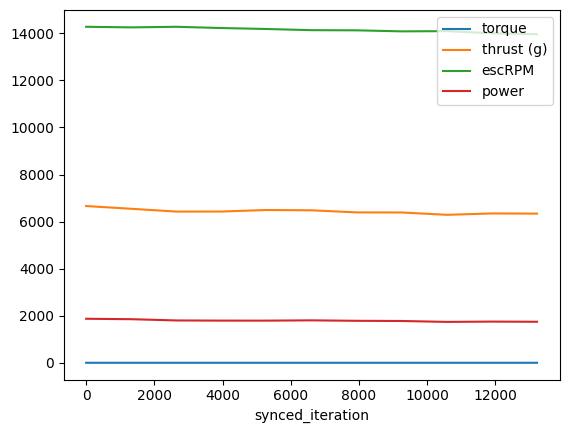

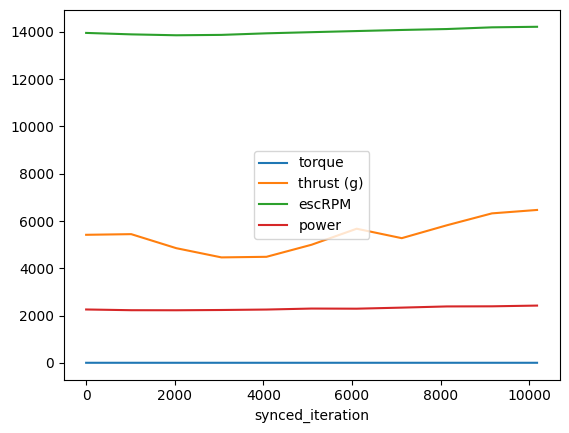

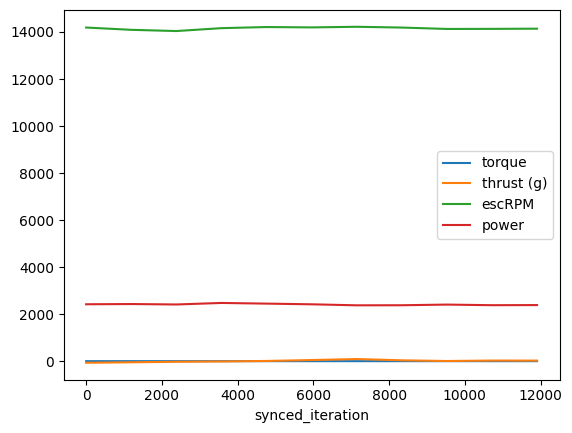

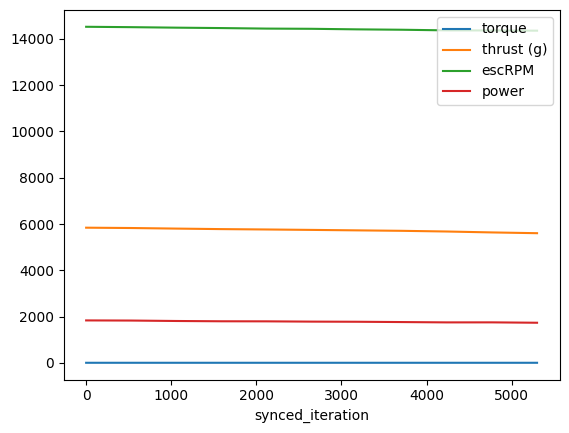

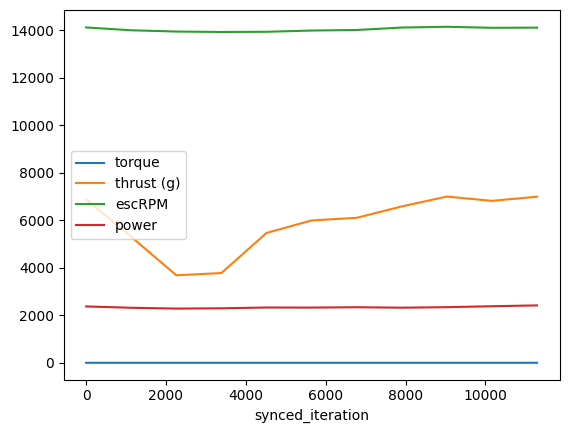

In [42]:
for file in files:
    df = pd.read_csv(file)
    df_simplified = simplify_data(df, 10)
    df_simplified.to_csv(OUTPUT_DIR + '/' + os.path.basename(file), index=False)
    df_simplified.plot(x='synced_iteration')